<a href="https://colab.research.google.com/github/Blurr99/tensorflow_deepLearning/blob/main/09_SkimLit_NLP_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper being replicated is `https://arxiv.org/abs/1710.06071`.

And the model being utilized in the paper above is availabe at: `https://arxiv.org/abs/1612.05251`.

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-5830417e-6596-b585-abbe-450671f40409)


## Getting the data

The data is publicly available on the author's GitHub: `https://github.com/Franck-Dernoncourt/pubmed-rct`

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 22.32 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [3]:
## Checking what files are present in PuubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
# Start the experiments using the 20k dataset with numbers replaced with the '@' sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + "/" + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign//dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign//test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign//train.txt']

## Preprocess data

Writing a function to read in all of the lines of a target text file.

In [6]:
# Creating function to read the lines of a document
def get_lines(filename):
  """
    Reads filename (a text file) and returns the lines of text as a list.

    Args:
      filename: a string containing the target filepath.

    Returns:
      A list of strings with one string per line from the target filename.
  """

  with open(filename, "r") as f:
    return f.readlines()

In [7]:
# Reading in the training lines
train_lines = get_lines(data_dir + "/train.txt")
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

How the data needs to be represented:
```
[
  {'line_number': 0,
   'target': 'BACKGROUND',
   'text': 'tEmotional eating is associated with overeating and the development of obesity .\n',
   'total_lines': 11
  }, ...
]
```

In [8]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [9]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 689 ms, sys: 132 ms, total: 821 ms
Wall time: 869 ms


(180040, 30212, 30135)

In [10]:
# Checking the first abstract of the training data
train_samples[:12]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [11]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
test_df = pd.DataFrame(test_samples)
val_df = pd.DataFrame(val_samples)

train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [12]:
# Checking the distribution of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

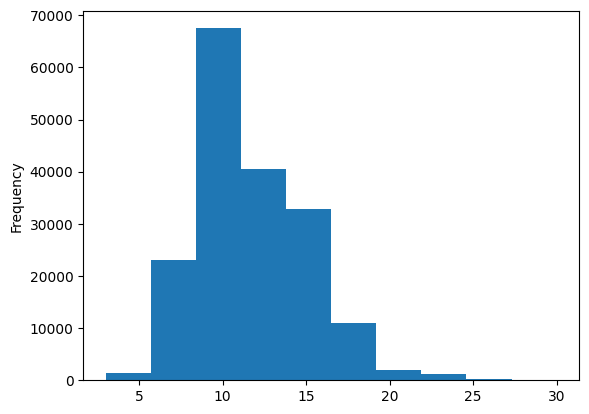

In [13]:
train_df.total_lines.plot.hist();

### Get lists of sentences

In [14]:
# Convert abstract text lines into lists
train_sentences = train_df['text'].to_list()
test_sentences = test_df['text'].to_list()
val_sentences = val_df['text'].to_list()

len(train_sentences), len(test_sentences), len(val_sentences)

(180040, 30135, 30212)

In [15]:
# View the first 10 lines of train sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels

In [16]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape((-1,1)))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

test_labels_one_hot.shape

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(30135, 5)

## Label encode labels

In [17]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))

# Checking training labels
train_labels_encoded

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


array([3, 2, 2, ..., 4, 1, 1])

In [18]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Getting a Baseline

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [20]:
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [21]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [22]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

In [23]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-03-05 05:56:16--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-03-05 05:56:16 (74.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [24]:
from helper_functions import calculate_results

In [25]:
# Calculate baseline results
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing the data (words) for deep sequence modelling

In [26]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
import numpy as np

In [27]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_lens = np.mean(sent_lens)
avg_sent_lens

26.338269273494777

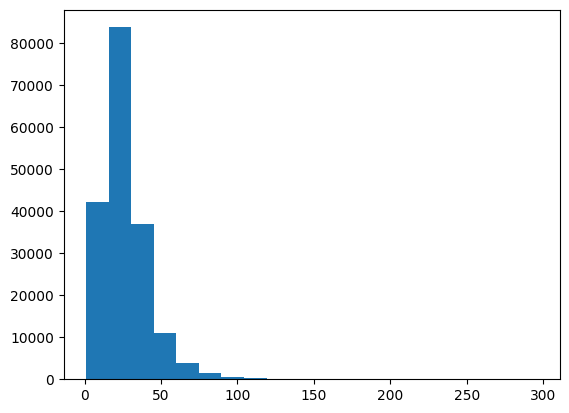

In [28]:
# Checking the distribution
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins = 20);

In [29]:
# How long of a sentence length covers 95% of the sentences
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

## Creating a Text Vectorization layer

In [30]:
max_tokens = 68000

text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                       output_sequence_length = output_seq_len)

In [31]:
# Adapt text_vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [32]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text: \n {target_sentence}")
print(f"\nLength of Text: {len(target_sentence.split())}\n")
print(f"Vectorized Text: {text_vectorizer([target_sentence])}")

Text: 
 those in the control group only received the conventional therapy .

Length of Text: 11

Vectorized Text: [[125   5   2  35  13 192  80   2 366  66   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]


In [33]:
# Checking out the vocabulary
rct_20k_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in the vocabulary: {len(rct_20k_vocab)}")
print(f"5 Most used words: {rct_20k_vocab[:5]}")
print(f"\n 5 Least used words: {rct_20k_vocab[-5:]} ")

Number of words in the vocabulary: 64841
5 Most used words: ['', '[UNK]', 'the', 'and', 'of']

 5 Least used words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp'] 


In [34]:
# Configuration of the Text Vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

## Create custom text embedding

In [35]:
token_embed = layers.Embedding(input_dim = len(rct_20k_vocab),
                              output_dim = 128,
                              mask_zero = True,
                              name = "token_embedding")

In [36]:
# Showing an example of embedding
print(f"Sentence before vectorization: \n {target_sentence}")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"\n Sentence after vectorization: \n {vectorized_sentence}")
embedded_sentence = token_embed(vectorized_sentence)
print(f"\nSentence after embedding: {embedded_sentence}")
print(f"Embed sentence shape: {embedded_sentence.shape}")

Sentence before vectorization: 
 those in the control group only received the conventional therapy .

 Sentence after vectorization: 
 [[125   5   2  35  13 192  80   2 366  66   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]

Sentence after embedding: [[[ 0.03005593 -0.01684277 -0.03595952 ...  0.02432412 -0.03029726
   -0.01214755]
  [ 0.04431596 -0.02501668  0.03745449 ... -0.02862675  0.0478775
    0.04663226]
  [ 0.04807354  0.04592768 -0.03360241 ...  0.02777741 -0.00769458
   -0.04741722]
  ...
  [-0.04965958 -0.0374277   0.04201051 ...  0.00703961  0.04357008
    0.0407379 ]
  [-0.04965958 -0.0374277   0.04201051 ...  0.00703961  0.04357008
    0.0407379 ]
  [-0.04965958 -0.0374277   0.04201051 ...  0.00703961  0.04357008
    0.0407379 ]]]
Embed sentence shape: (1, 55, 128)


## Creating datasets

In [37]:
len(test_sentences), test_labels_one_hot.shape

(30135, (30135, 5))

In [38]:
# Turn the data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [39]:
# Take the TensorSliceDatasets and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Model 1: Conv1D with token embeddings

In [40]:
# Creating a model
inputs = layers.Input(shape = (1,), dtype = tf.string)
text_vectors = text_vectorizer(inputs)
text_embeddings = token_embed(text_vectors)
x = layers.Conv1D(filters = 64,
                  kernel_size = 5,
                  padding = "same",
                  activation = "relu")(text_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation = "softmax")(x)
model_1 = tf.keras.Model(inputs, outputs, name = "model_1_Conv1D")

# Compiling the model
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = "accuracy")

In [41]:
model_1.summary()

Model: "model_1_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                    

In [42]:
# Fit the model
history_1 = model_1.fit(train_dataset,
                        steps_per_epoch = int(0.1 * len(train_dataset)),
                        epochs = 3,
                        validation_data = valid_dataset,
                        validation_steps = int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 20s 30ms/step - loss: 0.9203 - accuracy: 0.6338 - val_loss: 0.6868 - val_accuracy: 0.7387
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6604 - accuracy: 0.7533 - val_loss: 0.6334 - val_accuracy: 0.7743
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6200 - accuracy: 0.7732 - val_loss: 0.5961 - val_accuracy: 0.7869


In [43]:
# Evaluate on the entire validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5993 - accuracy: 0.7865


[0.5993219017982483, 0.7864755988121033]

In [44]:
# Make predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[4.4364977e-01, 1.6354713e-01, 8.8569641e-02, 2.7285537e-01,
         3.1378023e-02],
        [4.5163637e-01, 2.6543236e-01, 1.2068671e-02, 2.6404282e-01,
         6.8198335e-03],
        [1.5674557e-01, 9.4403718e-03, 3.0617460e-03, 8.3067745e-01,
         7.4843461e-05],
        ...,
        [3.0579401e-06, 4.8786681e-04, 5.1097194e-04, 1.6335305e-06,
         9.9899644e-01],
        [7.1768582e-02, 4.7179189e-01, 9.5349401e-02, 7.8095689e-02,
         2.8299448e-01],
        [1.7745389e-01, 6.4792007e-01, 3.8086258e-02, 6.5613233e-02,
         7.0926547e-02]], dtype=float32),
 (30212, 5))

In [45]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [46]:
# Calculate model_1 results
model_1_results = calculate_results(val_labels_encoded, model_1_preds)
model_1_results

{'accuracy': 78.64755726201508,
 'precision': 0.7832408023216915,
 'recall': 0.7864755726201509,
 'f1': 0.7841791656473075}

# Model 2: Feature Extraction with pretrained token embeddings

In [47]:
import tensorflow_hub as hub
# Create a Keras layer using the USE pretrained layer from Kaggle
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

In [48]:
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence: \n {random_train_sentence}")
use_embed_text = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding: \n {use_embed_text[0][:30]}")
print(f"Length of sentence embedding: {len(use_embed_text[0])}")

Random sentence: 
 we audited charts to determine if target diagnoses were present and documented .
Sentence after embedding: 
 [ 0.0046033   0.02334469  0.02644729  0.01431591  0.06164515  0.01066134
 -0.07645879  0.019066   -0.05498971  0.00533511  0.09009354 -0.00011037
  0.03776526  0.05950835 -0.07158512 -0.00201572 -0.07843515 -0.00453207
 -0.01102412  0.00048124  0.0293619   0.06201038 -0.02936589 -0.03195565
  0.02368471  0.04471143 -0.05180229  0.06528772  0.08428238  0.02000038]
Length of sentence embedding: 512


### Building and fitting a feature extraction model with pretrained embeddings

In [49]:
# Define feature extraction model using TF Hub layer
inputs = layers.Input(shape = [], dtype = tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation = "relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation = "softmax")(x)

model_2 = tf.keras.Model(inputs, outputs, name = "model_2_USE")

# Compile the model
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

model_2.summary()

Model: "model_2_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [50]:
# Fit model_2
history_2 = model_2.fit(train_dataset,
                        steps_per_epoch = int(0.1 * len(train_dataset)),
                        epochs = 3,
                        validation_data = valid_dataset,
                        validation_steps = int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 15ms/step - loss: 0.9196 - accuracy: 0.6495 - val_loss: 0.7991 - val_accuracy: 0.6905
Epoch 2/3
562/562 [==============================] - 8s 15ms/step - loss: 0.7692 - accuracy: 0.7020 - val_loss: 0.7577 - val_accuracy: 0.7048
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7532 - accuracy: 0.7114 - val_loss: 0.7413 - val_accuracy: 0.7118


In [51]:
# Evaluating the model with the entire validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 9s 10ms/step - loss: 0.7428 - accuracy: 0.7121


[0.7427954077720642, 0.71210116147995]

In [52]:
# Making predictions with the feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 8s 8ms/step


array([[0.41181782, 0.3778887 , 0.00238055, 0.1991597 , 0.00875318],
       [0.32872546, 0.5255968 , 0.00446466, 0.1377112 , 0.00350195],
       [0.2141193 , 0.14890899, 0.01806087, 0.5860055 , 0.03290528],
       ...,
       [0.00157712, 0.00743966, 0.06584334, 0.00103082, 0.92410904],
       [0.00358253, 0.04662651, 0.223614  , 0.0014792 , 0.7246977 ],
       [0.17107928, 0.19713132, 0.56559306, 0.0065552 , 0.0596411 ]],
      dtype=float32)

In [53]:
# Converting the pred probs into predictions
model_2_preds = tf.argmax(model_2_pred_probs, axis = 1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [54]:
# Calculate the results
model_2_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 71.2101151860188,
 'precision': 0.7126955957095811,
 'recall': 0.712101151860188,
 'f1': 0.708851690545347}

# Model 3: Conv1D with character embeddings

### Creating a character-level vectorizer

In [55]:
# Make a function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

split_chars(random_train_sentence)

'w e   a u d i t e d   c h a r t s   t o   d e t e r m i n e   i f   t a r g e t   d i a g n o s e s   w e r e   p r e s e n t   a n d   d o c u m e n t e d   .'

In [56]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [57]:
# Average character length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_lens = np.mean(char_lens)
mean_char_lens

149.3662574983337

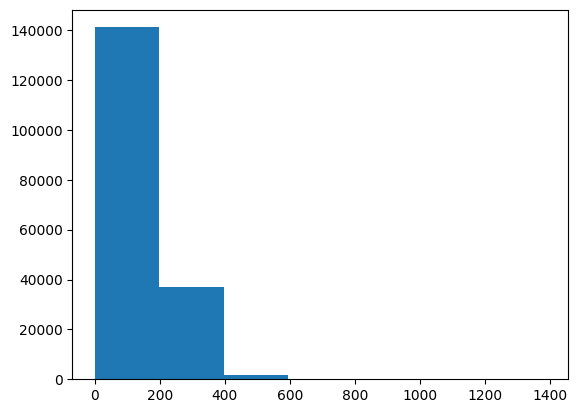

In [58]:
import matplotlib.pyplot as plt
plt.hist(char_lens, bins = 7);

In [59]:
# Find what character length covers 95% of sentences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [60]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [61]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    name = "char_vectorizer")

In [62]:
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [63]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"\nMost common characters: {char_vocab[:5]}\n")
print(f"Least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28

Most common characters: ['', '[UNK]', 'e', 't', 'i']

Least common characters: ['k', 'x', 'z', 'q', 'j']


In [64]:
# Testing out random character vectorizer
random_train_char = random.choice(train_chars)
print(f"Charified text: \n {random_train_char}")
print(f"Length of charified text: {len(random_train_char.split())}")
vectorized_chars = char_vectorizer([random_train_char])
print(f"Vectorized chars:\n {vectorized_chars}")
print(f"Length of vectorized chars: {len(vectorized_chars[0])}")

Charified text: 
 w e i g h t   l o s s   w a s   a s s o c i a t e d   w i t h   a   @   %   i n c r e a s e   i n   t h e   r i s k   o f   a l l - c a u s e   m o r t a l i t y   (   h r   @   ,   @   %   c i   @ - @   @   ;   p   =   @   )   .
Length of charified text: 86
Vectorized chars:
 [[20  2  4 18 13  3 12  7  9  9 20  5  9  5  9  9  7 11  4  5  3  2 10 20
   4  3 13  5  4  6 11  8  2  5  9  2  4  6  3 13  2  8  4  9 23  7 17  5
  12 12 11  5 16  9  2 15  7  8  3  5 12  4  3 19 13  8 11  4 14  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0 

### Creating a character-level embedding

In [65]:
char_embed = layers.Embedding(input_dim = len(char_vocab),
                              output_dim = 25,
                              mask_zero = True,
                              name = 'char_embed')

In [66]:
# Testing the embedding layer
print(f"Charified text: \n {random_train_char}\n")
char_embed_example = char_embed(char_vectorizer([random_train_char]))
print(f"Embedded chars: \n {char_embed_example}\n")
print(f"Character Embedding shape: {char_embed_example.shape}")

Charified text: 
 w e i g h t   l o s s   w a s   a s s o c i a t e d   w i t h   a   @   %   i n c r e a s e   i n   t h e   r i s k   o f   a l l - c a u s e   m o r t a l i t y   (   h r   @   ,   @   %   c i   @ - @   @   ;   p   =   @   )   .

Embedded chars: 
 [[[-0.03258224 -0.00573571 -0.02243273 ... -0.00615727 -0.04023518
   -0.02986133]
  [ 0.04613649 -0.04263884 -0.02207731 ... -0.04750602  0.00955374
   -0.00498047]
  [ 0.03687542 -0.02271004  0.04313738 ... -0.0472432  -0.01365341
    0.03526772]
  ...
  [-0.04926078 -0.04322552  0.02535195 ...  0.02086652  0.0300327
   -0.03361261]
  [-0.04926078 -0.04322552  0.02535195 ...  0.02086652  0.0300327
   -0.03361261]
  [-0.04926078 -0.04322552  0.02535195 ...  0.02086652  0.0300327
   -0.03361261]]]

Character Embedding shape: (1, 290, 25)


### Creating the conv1D model

In [67]:
inputs = layers.Input(shape = (1,), dtype = "string")
vectorized_text = char_vectorizer(inputs)
embedded_text = char_embed(vectorized_text)
x = layers.Conv1D(64,
                  kernel_size = 5,
                  padding = "same",
                  activation = "relu")(embedded_text)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation = "softmax")(x)

model_3 = tf.keras.Model(inputs, outputs, name = "model_3_Conv1D_with_char_embed")

In [68]:
model_3.summary()

Model: "model_3_Conv1D_with_char_embed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 

In [69]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [70]:
# Compiling the model
model_3.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [71]:
# Fit the model on chars only
history_3 = model_3.fit(train_char_dataset,
                        steps_per_epoch = int(0.1 * len(train_char_dataset)),
                        epochs = 3,
                        validation_data = val_char_dataset,
                        validation_steps = int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 6ms/step - loss: 1.2667 - accuracy: 0.4934 - val_loss: 1.0400 - val_accuracy: 0.5911
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0102 - accuracy: 0.5948 - val_loss: 0.9492 - val_accuracy: 0.6227
Epoch 3/3
562/562 [==============================] - 4s 6ms/step - loss: 0.9324 - accuracy: 0.6328 - val_loss: 0.8717 - val_accuracy: 0.6636


In [72]:
# Make predictions with character embedding model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.16900732, 0.42147   , 0.14378844, 0.22241494, 0.04331928],
       [0.17315564, 0.5740281 , 0.04688554, 0.06546118, 0.14046961],
       [0.11493837, 0.1939209 , 0.42628783, 0.15275775, 0.11209517],
       ...,
       [0.03001653, 0.04141589, 0.14261453, 0.03118395, 0.7547691 ],
       [0.03599061, 0.14013115, 0.26634464, 0.02050094, 0.53703266],
       [0.4535717 , 0.36263776, 0.06430035, 0.11180861, 0.00768162]],
      dtype=float32)

In [73]:
# Convert pred probs to predictions
model_3_preds = tf.argmax(model_3_pred_probs, axis = 1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 2, ..., 4, 4, 0])>

In [74]:
# Calculate results
model_3_results = calculate_results(y_true = val_labels_encoded,
                  y_pred = model_3_preds)
model_3_results

{'accuracy': 65.48391367668475,
 'precision': 0.6462537644635924,
 'recall': 0.6548391367668476,
 'f1': 0.6454216861787881}

## Model 4: Combining pretrained token embeddings + character embeddings
1. Token-level embedding model (similar to model_1)
2. Character-level model (similar to model_3 with some modifications)
3. Combining 1 & 2 with concatenate(layers.Concatenate)
4. Build a series of output layers on top of 3.
5. Construct a model that takes token and character-level sequences as input and produces sequence label probabilities as output.

In [75]:
# 1. Setup token inputs
token_inputs = layers.Input(shape = [], dtype = tf.string, name = "token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape = (1,), dtype = tf.string, name = "char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name = "token_char_hybrid")([token_model.output,
                                                                    char_model.output])

# 4. Create output layers - adding in Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation = "relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation = "softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
                         outputs = output_layer,
                         name = "model_4_token_and_char_embeddings")

In [76]:
# Summary of the model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 USE (KerasLayer)            (None, 512)                  2567978 

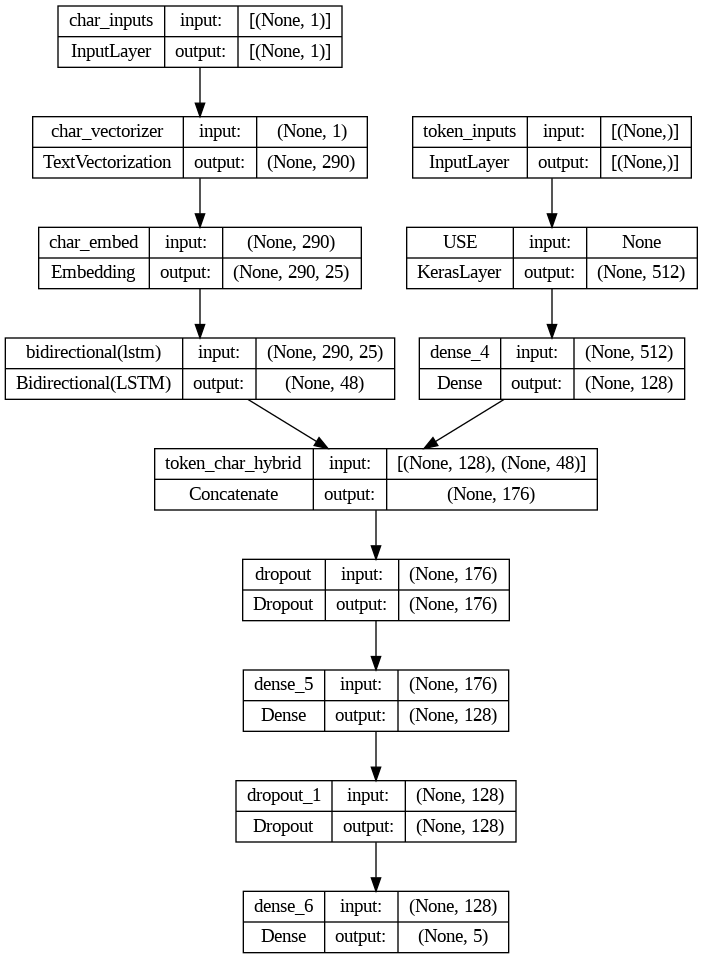

In [77]:
# Plot hybrid char and token model
from keras.utils import plot_model
plot_model(model_4, show_shapes = True)

In [78]:
# Combine token char model
model_4.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

### Combining token and character data into a tf.data Dataset

In [79]:
# Combine chars and tokens into a Dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [80]:
# Doing the same for the validation dataset and the testing dataset
# Combine chars and tokens into a Dataset
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

# Prefetch and batch train data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))

test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [81]:
# Checking the training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [82]:
# Fitting the model
history_4 = model_4.fit(train_char_token_dataset,
                        steps_per_epoch = int(0.1 * len(train_char_token_dataset)),
                        epochs = 3,
                        validation_data = val_char_token_dataset,
                        validation_steps = int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 39s 49ms/step - loss: 0.9777 - accuracy: 0.6105 - val_loss: 0.7794 - val_accuracy: 0.6978
Epoch 2/3
562/562 [==============================] - 24s 42ms/step - loss: 0.8018 - accuracy: 0.6922 - val_loss: 0.7188 - val_accuracy: 0.7234
Epoch 3/3
562/562 [==============================] - 22s 38ms/step - loss: 0.7737 - accuracy: 0.7037 - val_loss: 0.6882 - val_accuracy: 0.7311


In [83]:
# Evaluating the model on the entire validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 17s 18ms/step - loss: 0.6896 - accuracy: 0.7356


[0.6896345019340515, 0.7356017231941223]

In [84]:
# Making predictions on validation data
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 20s 19ms/step


array([[4.40616280e-01, 3.35427433e-01, 3.61711765e-03, 2.14227840e-01,
        6.11119345e-03],
       [3.47265989e-01, 3.65290225e-01, 4.85592382e-03, 2.79773116e-01,
        2.81471969e-03],
       [2.93334842e-01, 1.12863347e-01, 5.71672507e-02, 5.02928913e-01,
        3.37056369e-02],
       ...,
       [4.80300223e-04, 8.49985890e-03, 5.78452572e-02, 2.22157920e-04,
        9.32952404e-01],
       [6.94910297e-03, 4.02355343e-02, 3.13710302e-01, 2.90466822e-03,
        6.36200428e-01],
       [1.75052524e-01, 3.10811788e-01, 3.96664321e-01, 1.56817734e-02,
        1.01789564e-01]], dtype=float32)

In [85]:
# Converting model_4 prediction probabilities into predictions
model_4_preds = tf.argmax(model_4_pred_probs, axis = 1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [86]:
# Calculating the results
model_4_results = calculate_results(y_true = val_labels_encoded,
                  y_pred = model_4_preds)
model_4_results

{'accuracy': 73.56017476499404,
 'precision': 0.7336873336677445,
 'recall': 0.7356017476499405,
 'f1': 0.7323454463105906}

## Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

> **Note**: Engineered features used to train a model should be available at test time.

### Create positional embeddings

In [87]:
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

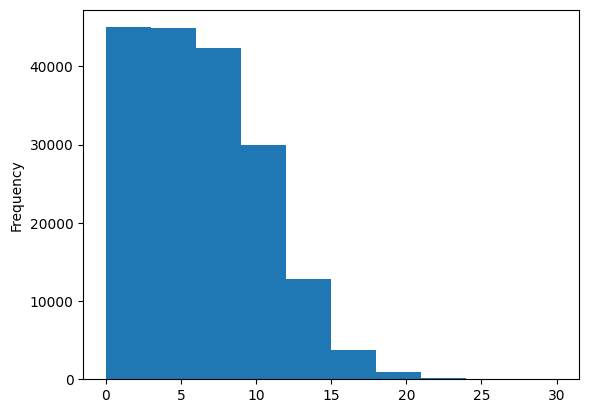

In [88]:
train_df.line_number.plot.hist()

In [89]:
# Use tensorflow to create one-hot encoded tensors to the 'line_number' column
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth = 15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [90]:
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

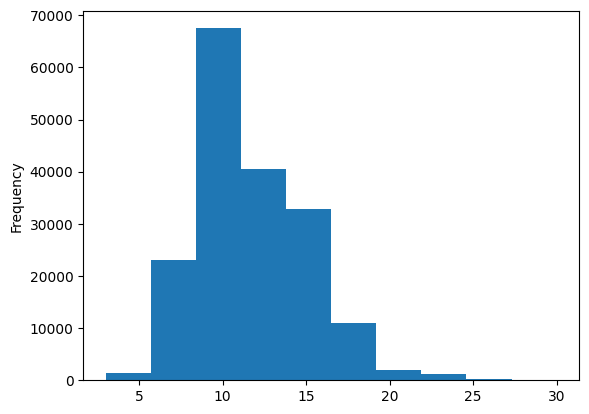

In [91]:
train_df.total_lines.plot.hist();

In [92]:
np.percentile(train_df.total_lines, 98)

20.0

In [93]:
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth = 20)
# train_total_lines_one_hot[:15], train_total_lines_one_hot.shape

### Building a tribrid embedding model
1. Create a token-level embedding.
2. Create a character-level embedding.
3. Create a model for the 'line_number' feature.
4. Create a model for the 'total_line' feature.
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate.
6. Combine the outputs of 3, 4 & 5 using tf.keras.layers.Concatenate.
7. Create an output layer to accept the tribied embedding and output layer probabilities.
8. Combine the inputs of 1, 2, 3 & 4 and outputs into a tf.keras.Model

In [94]:
# 1. Token inputs
token_inputs = layers.Input(shape = [], dtype = 'string', name = "token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape = (1,), dtype = "string", name = "char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Line number model
line_input = layers.Input(shape = (15,), dtype = tf.float32, name = "line_number_input")
x = layers.Dense(32, activation = "relu")(line_input)
line_model = tf.keras.Model(line_input, x)

# 4. Total line model
total_input = layers.Input(shape = (20,), dtype = tf.float32, name = "total_line_input")
y = layers.Dense(32, activation = "relu")(total_input)
total_model = tf.keras.Model(total_input, y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name = "char_token_embedding")([token_model.output, char_model.output])
z = layers.Dense(256, activation = "relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name = "char_token_positional_embedding")([line_model.output,
                                                                                   total_model.output,
                                                                                   z])

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation = "softmax", name = "output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs = [line_model.input, total_model.input, token_model.input, char_model.input],
                         outputs = output_layer, name = "tribrid_embedding_model")

In [95]:
# Getting the summary of the model
model_5.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 USE (KerasLayer)            (None, 512)                  2567978   ['token_

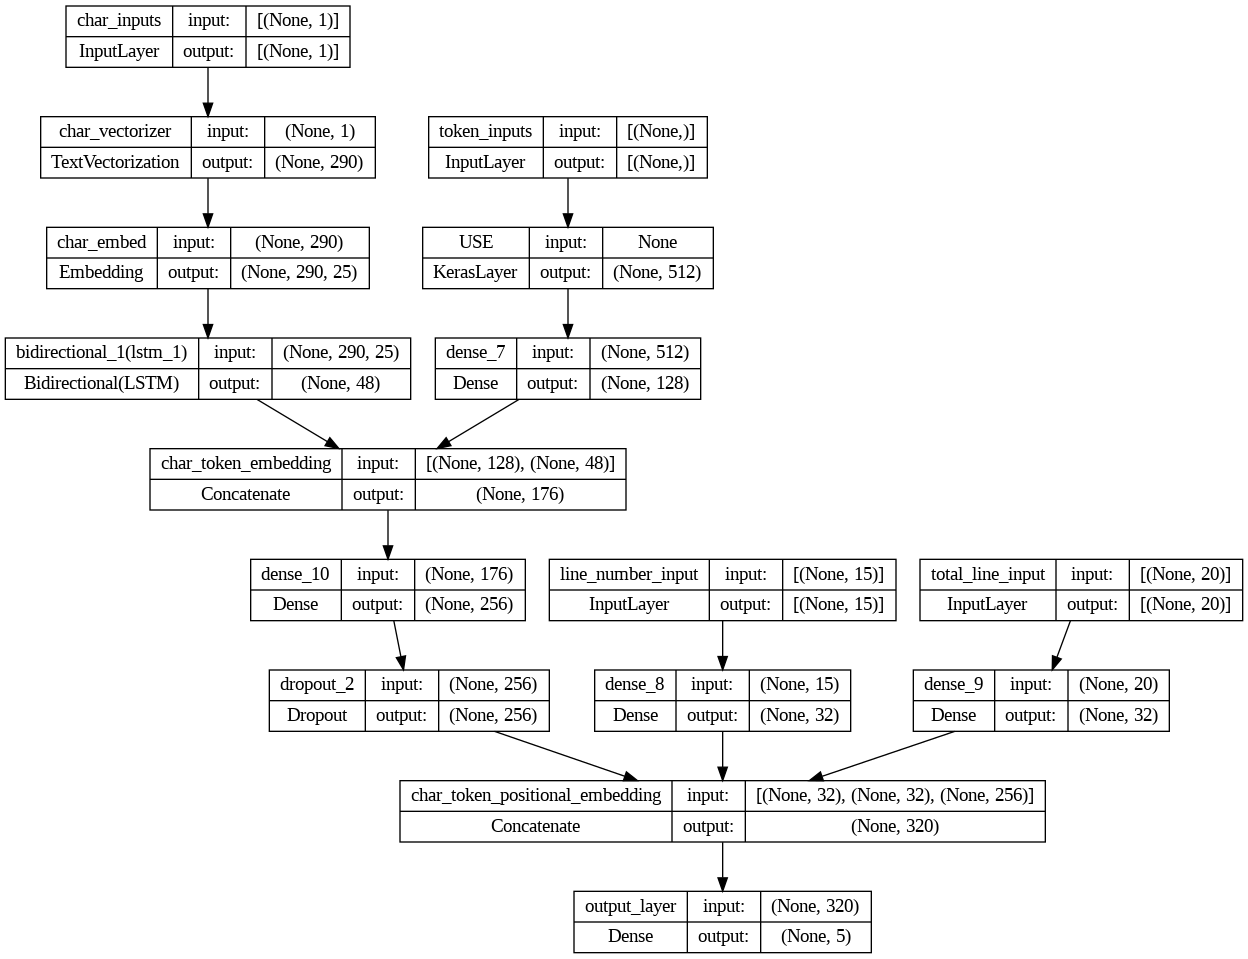

In [96]:
plot_model(model_5, show_shapes = True)

What is label smoothing?

For example, if the model gets too confident on a single class (really high prediction probability), it may get stuck on that class and not consider other classes.
>Really confident: [0.0, 0.0, 1.0, 0.0, 0.0]

What label smoothing does is that it assigns some of the value from the highest probability to other classes, in turn, hopefully improving generalization.
> After label smoothing: [0.1, 0.1, 0.96, 0.1, 0.1]

In [97]:
# Compile the model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2, from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Create tribrid embedding datasets using tf.data

In [98]:
# Create training and validation datasets
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, evaluating and making predictions using the tribrid model  

In [99]:
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


562/562 [==============================] - 37s 48ms/step - loss: 1.0904 - accuracy: 0.7289 - val_loss: 0.9762 - val_accuracy: 0.8125
Epoch 2/3
562/562 [==============================] - 26s 46ms/step - loss: 0.9644 - accuracy: 0.8163 - val_loss: 0.9457 - val_accuracy: 0.8291
Epoch 3/3
562/562 [==============================] - 22s 39ms/step - loss: 0.9472 - accuracy: 0.8245 - val_loss: 0.9376 - val_accuracy: 0.8314


In [100]:
# Evaluating the model on the entire validation dataset
model_5.evaluate(val_pos_char_token_dataset)

945/945 [==============================] - 18s 19ms/step - loss: 0.9349 - accuracy: 0.8352


[0.9349235892295837, 0.8352310061454773]

In [101]:
# Making predictions
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset)
model_5_pred_probs

945/945 [==============================] - 21s 19ms/step


array([[0.48975822, 0.10692855, 0.01201761, 0.37484518, 0.0164504 ],
       [0.56629956, 0.08383245, 0.04314849, 0.29440582, 0.0123136 ],
       [0.30084088, 0.10671226, 0.10473036, 0.42347348, 0.06424308],
       ...,
       [0.04042909, 0.107325  , 0.0382879 , 0.03173589, 0.78222215],
       [0.03446371, 0.317482  , 0.0969318 , 0.03399494, 0.5171276 ],
       [0.20153417, 0.609508  , 0.09630192, 0.04013466, 0.05252131]],
      dtype=float32)

In [102]:
# Converting prediction probabilities into predicted classes
model_5_preds = tf.argmax(model_5_pred_probs, axis = 1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [103]:
# Calculating the results
model_5_results = calculate_results(y_true = val_labels_encoded,
                             y_pred = model_5_preds)
model_5_results

{'accuracy': 83.52310340262147,
 'precision': 0.8344612006032462,
 'recall': 0.8352310340262148,
 'f1': 0.8341581642605075}

## Compare model results

In [104]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                 "model_1_custom_token_embedding": model_1_results,
                                 "model_2_pretrained_token_embedding": model_2_results,
                                 "model_3_custom_char_embedding": model_3_results,
                                 "model_4_hybrid_char_token_embedding": model_4_results,
                                 "model_5_pos_char_token_pos_embedding": model_5_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.647557,0.783241,0.786476,0.784179
model_2_pretrained_token_embedding,71.210115,0.712696,0.712101,0.708852
model_3_custom_char_embedding,65.483914,0.646254,0.654839,0.645422
model_4_hybrid_char_token_embedding,73.560175,0.733687,0.735602,0.732345
model_5_pos_char_token_pos_embedding,83.523103,0.834461,0.835231,0.834158


In [105]:
# Reduce the accuracy to same scale as other metrics
all_model_results['accuracy'] = all_model_results['accuracy'] / 100

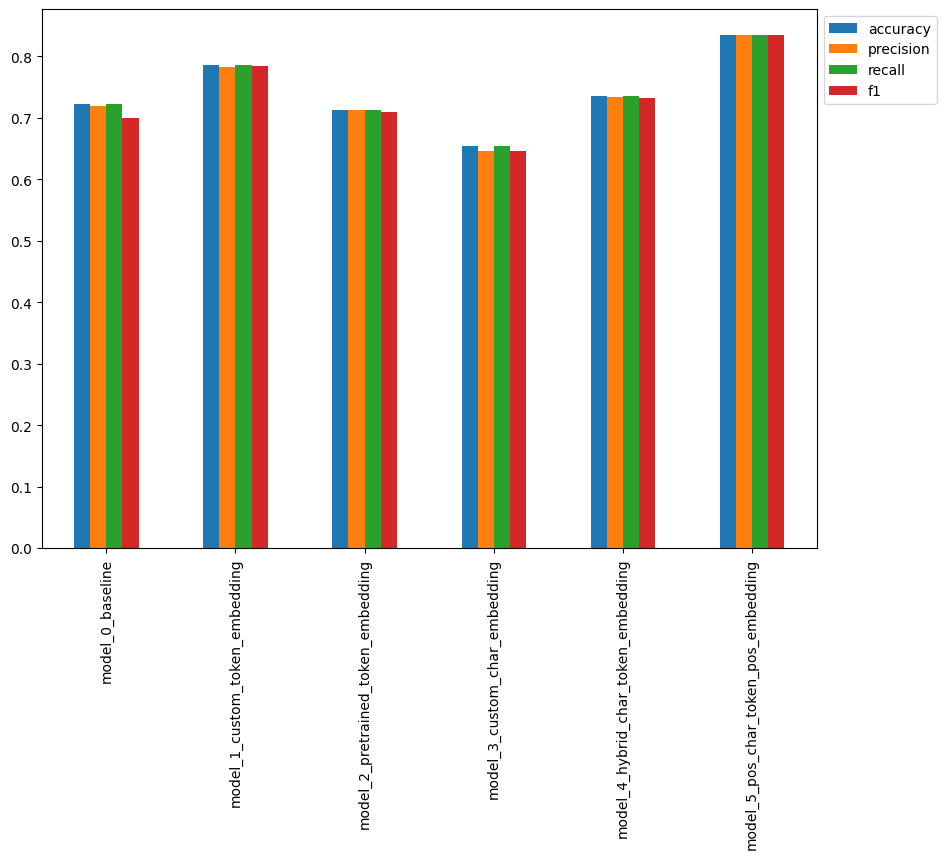

In [106]:
# Plot and compare all model results
all_model_results.plot(kind = 'bar', figsize = (10,7)).legend(bbox_to_anchor = (1.0, 1.0));

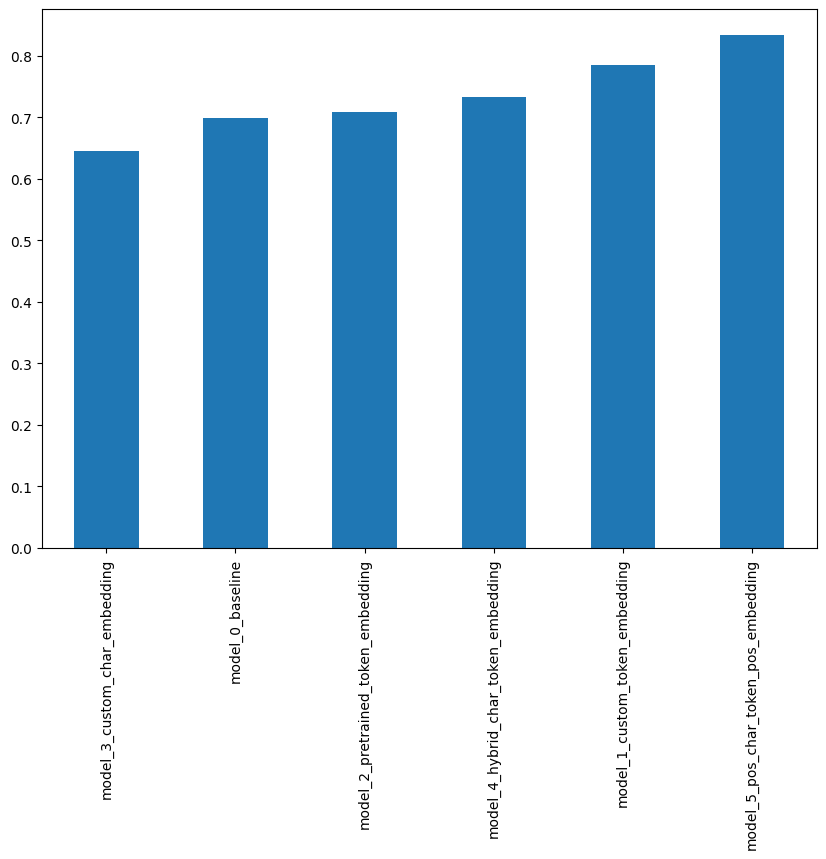

In [107]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending = True)["f1"].plot(kind = "bar", figsize = (10,7));

## Save and load model

In [108]:
# Save the best performing model
model_5.save("skimlit_tribrid_model")

In [109]:
# Load in best model
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")

In [110]:
# Making predictions with the loaded model
loaded_model_pred_probs = loaded_model.predict(val_pos_char_token_dataset)

945/945 [==============================] - 22s 19ms/step


In [111]:
# Converting model prediction probabilities into predicted classes
loaded_model_preds = tf.argmax(loaded_model_pred_probs, axis = 1)

In [112]:
loaded_model_results = calculate_results(y_true = val_labels_encoded,
                                         y_pred = loaded_model_preds)
loaded_model_results

{'accuracy': 83.52310340262147,
 'precision': 0.8344612006032462,
 'recall': 0.8352310340262148,
 'f1': 0.8341581642605075}

In [113]:
model_5_results

{'accuracy': 83.52310340262147,
 'precision': 0.8344612006032462,
 'recall': 0.8352310340262148,
 'f1': 0.8341581642605075}

In [114]:
# Check loaded model summaray
loaded_model.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 USE (KerasLayer)            (None, 512)                  2567978   ['token_

## Download and load in a pretrained model from Google Storage

In [116]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [117]:
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2024-03-05 06:21:03--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.207, 74.125.142.207, 74.125.195.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962182847 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.61M   114MB/s    in 11s     

2024-03-05 06:21:14 (86.8 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962182847/962182847]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
  inflating: skimlit_gs_model/skimlit_tribrid_model/keras_metadata.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/assets/
 extracting: skimlit_gs_model/skimlit_tribrid_model/fingerprint.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/

In [118]:
# Loading in the downloaded model
downloaded_model = tf.keras.models.load_model('skimlit_gs_model/skimlit_tribrid_model/')

In [119]:
downloaded_model_results = downloaded_model.evaluate(val_pos_char_token_dataset)
downloaded_model_results

945/945 [==============================] - 22s 20ms/step - loss: 0.9388 - accuracy: 0.8303


[0.9387755990028381, 0.830332338809967]

1. Turn the test data samples into tf.data Dataset and evaluate the best performing model on the test data.
2. Find the most wrong predictions from 1.
3. Make example predictions

### Turning test data into tf.data Datasets and preparing them for prefetching

In [120]:
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                test_total_lines_one_hot,
                                                test_sentences,
                                                test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)

test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset

<_ZipDataset element_spec=((TensorSpec(shape=(15,), dtype=tf.float32, name=None), TensorSpec(shape=(20,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None)), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [122]:
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [123]:
# Making predictions on test data
downloaded_model_pred_probs = downloaded_model.predict(test_pos_char_token_dataset)
downloaded_model_pred_probs

942/942 [==============================] - 27s 27ms/step


array([[0.29606265, 0.08308028, 0.03647107, 0.5238846 , 0.06050142],
       [0.30677012, 0.07795963, 0.22224794, 0.3519172 , 0.04110508],
       [0.06126453, 0.02438156, 0.8024585 , 0.07651208, 0.03538331],
       ...,
       [0.08204224, 0.07113037, 0.08104055, 0.07469936, 0.6910875 ],
       [0.06454715, 0.06645508, 0.08340038, 0.05865363, 0.72694373],
       [0.09589875, 0.54456496, 0.13930307, 0.06724537, 0.15298791]],
      dtype=float32)

In [124]:
# Converting prediction probabilities into predicted classes
downloaded_model_preds = tf.argmax(downloaded_model_pred_probs, axis = 1)
downloaded_model_preds

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 3, 2, ..., 4, 4, 1])>

In [125]:
downloaded_model_results = calculate_results(y_true = test_labels_encoded,
                                             y_pred = downloaded_model_preds)
downloaded_model_results

{'accuracy': 82.57176041148166,
 'precision': 0.8242659626849546,
 'recall': 0.8257176041148167,
 'f1': 0.8247141207593822}

In [136]:
tf.reduce_max(downloaded_model_pred_probs, axis = 1)

<tf.Tensor: shape=(30135,), dtype=float32, numpy=
array([0.5238846 , 0.3519172 , 0.8024585 , ..., 0.6910875 , 0.72694373,
       0.54456496], dtype=float32)>

In [137]:
test_predictions_df = pd.DataFrame({
    'Text': test_sentences,
    'Prediction_prob': tf.reduce_max(downloaded_model_pred_probs, axis = 1),
    'Predicted_class': downloaded_model_preds,
    'Actual_class': test_labels_encoded
})
test_predictions_df.head()

,Text,Prediction_prob,Predicted_class,Actual_class
0,this study analyzed liver function abnormaliti...,0.523885,3,0
1,a post hoc analysis was conducted with the use...,0.351917,3,4
2,liver function tests ( lfts ) were measured at...,0.802459,2,4
3,survival analyses were used to assess the asso...,0.652782,2,4
4,the percentage of patients with abnormal lfts ...,0.665070,4,4


In [145]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [144]:
test_predictions_df[test_predictions_df['Predicted_class'] != test_predictions_df['Actual_class']].sort_values('Prediction_prob', ascending = False)[:10]

,Text,Prediction_prob,Predicted_class,Actual_class
13874,symptom outcomes will be assessed and estimate...,0.946719,2,1
8545,pretest-posttest .,0.934974,0,2
16347,to evaluate the effects of the lactic acid bac...,0.930986,3,0
2388,the primary endpoint is the cumulative three-y...,0.928262,2,4
10452,to validate the association between accommodat...,0.918880,3,0
13598,-@ % vs. fish : -@ % vs. fish + s : -@ % ; p <...,0.916908,4,2
23630,the primary outcome was to evaluate changes in...,0.915075,2,4
3573,a cluster randomised trial was implemented wit...,0.914345,2,4
16633,clinicaltrials.gov identifier : nct@ .,0.910313,0,1
1827,nct@ ( clinicaltrials.gov ) .,0.906662,0,1
